<a href="https://colab.research.google.com/github/atharva0300/Learn-Cuda/blob/main/learn_cuda_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
pip install nvcc4jupyter

In [16]:
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [17]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-7 60 --slave /usr/bin/g++ g++ /usr/bin/g++-7

update-alternatives: error: alternative path /usr/bin/gcc-7 doesn't exist


In [18]:
!gcc --version

gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



# Thread Organization
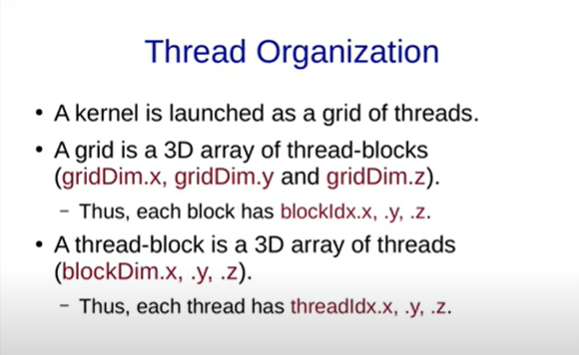

If the gridDim values are 10 , 5 ,6 for x ,y ,z respectively
Then the range of the grid Dim values will be
1. 0 - 9 for x
2. 0 - 4 for y
3. 0 - 5 for z

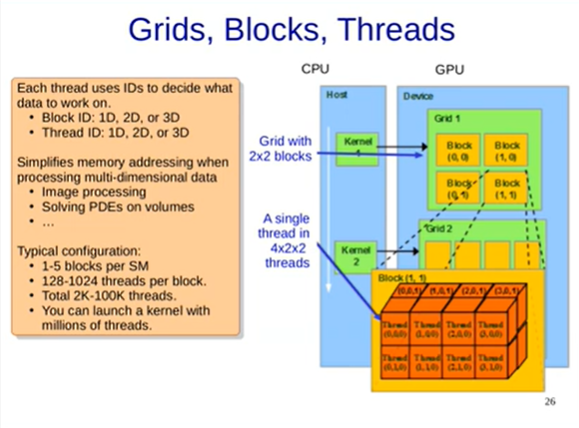

# Accessing Dimensions

In [19]:
%%cuda
#include<bits/stdc++.h>
#include<cuda.h>

using namespace std;

__global__ void dbkernel(){
    if(threadIdx.x == 0 && blockIdx.x == 0 &&
       threadIdx.y == 0 && blockIdx.y == 0 &&
       threadIdx.z == 0 && blockIdx.z == 0 ){
           printf("%d %d %d %d %d %d\n" , gridDim.x , gridDim.y , gridDim.z , blockDim.x , blockDim.y , blockDim.z);
          // there is only one value for which the condition is satisfied
        }
}

int main(){
    // dim3 is a class from cuda.h header file which is used to give the dimensions for the
    // grid or the thread-block

    dim3 grid(2,3,4); // A 3D array of thread-blocks of dimensions 2,3,4 -> this forms a grid

    dim3 block(5,6,7);  // a 3D array of threads of dimensions 5,6,7 -> this forms a thread-block

    dbkernel<<<grid , block>>>(); // passing the grid and the block to the function and launch the function
    // the kernel will be launched with 2*3*4*5*6*7 -> 7! threads
    // which is grid size * block size -> 7! threads

    // synchronize the device and the host
    cudaDeviceSynchronize();

    return 0;
}

2 3 4 5 6 7



# 2D

In [20]:
%%cuda
#include<bits/stdc++.h>
using namespace std;

#define N 5
#define M 6

__global__ void dbkernel(unsigned *matrix){
    // kernel function to initialize the matrix to unique ids
    unsigned id = threadIdx.x * blockDim.y + threadIdx.y;
    // blockDim.y will always be constant here which is 6
    matrix[id] = id;
}

int main(){
    dim3 block(N , M, 1);
    // block with 2 dimensions. The 3rd dim is set to 1

    unsigned *matrix, *hmatrix;
    // matrix pointer points to the GPU
    // hmatrix ( host matrix ) pointer points to the host memory

    cudaMalloc(&matrix, N*M*sizeof(unsigned));
    // allocate the memory of size N*M*sizeof(unsigned) in the GPU and have the matrix pointer
    // point to the address of the 1st memory block

    hmatrix = (unsigned*)malloc(N*M*sizeof(unsigned));
    // allocate the memory of size N*M*sizeof(unsigned) to the host CPU memory
    // and have the hmatrix pointer point to the 1st address of the memory block

    dbkernel<<<1 , block>>>(matrix);
    // pass the grid and the block
    // the grid size is 1 ( as there is only 1 block )
    // the block size is the array of threads ( the block here is a 2D array of threads )
    // the number of threads the kernel will be launched is -> 1*1*1*5*6*1 -> 5*6 -> 30 threads

    cudaMemcpy(hmatrix , matrix, N*M*sizeof(unsigned) , cudaMemcpyDeviceToHost);
    // copy the memory from GPU ( matrix pointer ) to the host cpu memory ( hmatrix ) pointer
    // of the same size as N*M*sizeof(unsigned)


    // display the values in the memory location's s
    // incrememt the hmatrix pointer to traverse the target memory block
    for(unsigned i=0; i<N;i++){
        for(unsigned j=0;j<M;j++){
            printf("%2d\t" , hmatrix[i*M+j]);
        }
        printf("\n");
    }

    return 0;
}

 0	 1	 2	 3	 4	 5	
 6	 7	 8	 9	10	11	
12	13	14	15	16	17	
18	19	20	21	22	23	
24	25	26	27	28	29	



# 1D

In [21]:
%%cuda
#include<bits/stdc++.h>
#include<cuda.h>

#define N 5
#define M 6

using namespace std;

__global__ void dbkernel(unsigned *matrix){
    // kernel function to initialize the matrix to unique ids

    unsigned id = blockIdx.x * blockDim.x + threadIdx.x;
    matrix[id] = id;
}

int main(){
    unsigned *matrix, *hmatrix;

    cudaMalloc(&matrix, N*M*sizeof(unsigned));
    hmatrix = (unsigned*)malloc(N*M*sizeof(unsigned));

    dbkernel<<<N , M>>>(matrix);
    // N -> 5 so 5 blocks in the grid ( 1 dimension , so only x will be there, no y,z)
    // M -> 6 so 6 threads in a thread=block ( 1 dimention , so only x will be there, no y,z)
    // total number of threads -> 5*6 -> 30 threads
    // the thread id will be from 0 to 29

    cudaMemcpy(hmatrix, matrix, N*M*sizeof(unsigned) , cudaMemcpyDeviceToHost);

    for(unsigned i=0;i<N;i++){
        for(unsigned j=0;j<M;j++){
            printf("%2d\t" , hmatrix[i*M+j]);
        }
        printf("\n");
    }

    return 0;

}

 0	 1	 2	 3	 4	 5	
 6	 7	 8	 9	10	11	
12	13	14	15	16	17	
18	19	20	21	22	23	
24	25	26	27	28	29	



# Key takeaway
1. One can perform computation on multi-dimensional data using a one-dimensional block

if we want the launch configuration to be <<<2 , X>>>
What is X for the output to remain same ?


In [22]:
%%cuda
#include<bits/stdc++.h>
#include<cuda.h>

#define N 5
#define M 6

using namespace std;

__global__ void dbkernel(unsigned *matrix){
    // kernel function to initialize the matrix to unique ids

    unsigned id = blockIdx.x * blockDim.x + threadIdx.x;
    matrix[id] = id;
}

int main(){
    unsigned *matrix, *hmatrix;

    cudaMalloc(&matrix, N*M*sizeof(unsigned));
    hmatrix = (unsigned*)malloc(N*M*sizeof(unsigned));

    dbkernel<<<2 , 15>>>(matrix);
    // N -> 5 so 5 blocks in the grid ( 1 dimension , so only x will be there, no y,z)
    // M -> 6 so 6 threads in a thread=block ( 1 dimention , so only x will be there, no y,z)
    // total number of threads -> 5*6 -> 30 threads
    // the thread id will be from 0 to 29

    cudaMemcpy(hmatrix, matrix, N*M*sizeof(unsigned) , cudaMemcpyDeviceToHost);

    for(unsigned i=0;i<N;i++){
        for(unsigned j=0;j<M;j++){
            printf("%2d\t" , hmatrix[i*M+j]);
        }
        printf("\n");
    }

    return 0;

}

/tmp/tmp468eyy0o/da305e1b-3272-4a48-be79-e8fdc6cfce68/single_file.cu(6): error: this declaration has no storage class or type specifier
  s
  ^

/tmp/tmp468eyy0o/da305e1b-3272-4a48-be79-e8fdc6cfce68/single_file.cu(7): error: expected a ";"
  using namespace std;
  ^

2 errors detected in the compilation of "/tmp/tmp468eyy0o/da305e1b-3272-4a48-be79-e8fdc6cfce68/single_file.cu".



X should be 15
Because 2*15 = 30 -> Number of threads